In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import Avogadro as N_A
from scipy.constants import elementary_charge as q
from scipy.constants import Boltzmann as kB
from scipy.constants import epsilon_0 as eps0
from scipy.optimize import curve_fit
import eckstein_yield as eck
from uncertainties import ufloat
from uncertainties.umath import log as ulog
from uncertainties.umath import log10 as ulog10
import eckstein_yield as ey
import pandas as pd
pi = np.pi


In [2]:
# Load Wirz Time-Dependent data from fig11
measured_da_data = pd.read_csv('wirz-time_dependent_fig11.csv', names=['T', 'da'])


In [60]:

def beam_volume(h, r1, r2):
    return (h*pi)*(r1-r2)

def erosion_rate(flux, sputter_yield, target_atomic_weight, target_density):
    return flux * sputter_yield * (target_atomic_weight / (target_density * N_A))

def cex_erosion_flux(flux_cex, single_doube_ratio, single_yield, double_yield, single_xsection, double_xsection):
    A = flux_cex / (1+single_doube_ratio)
    B = (single_doube_ratio/2) * (double_xsection/single_xsection)
    return A * (single_yield + B*double_yield)

def cex_flux(j, n0, single_xsection, volume):
    return (j/q) * n0 * single_xsection * volume

def beam_area_model(j_bar=1, a=0.619, b=0.011, c=-0.045):
    return a/j_bar + b*j_bar + c

def xe_xsections(E, charge = "+"):
    ''' Calculates the xenon CEX collision cross sections [Miller, 2002]

    Keyword arguments 
    E      -- incident ion energy
    charge -- incident ion charge (default = singly charged) 
    '''
    # Ignore for now
    ucoeffs = {
        "+"  : [ufloat(87.3, 0.9), ufloat(13.6, 0.6)],
        "++" : [ufloat(45.7, 1.9), ufloat(8.9, 1.2)]
    } # save ufloat for later when I have more time
    coeffs = {
        "+"  : [87.3, 13.6],
        "++" : [45.7, 8.9]
    }
    A = coeffs[charge][0]
    B = coeffs[charge][1]
    return A - B * ulog10(E)

def beam_area_ratio(j):
    a = 0.619
    b = 0.011
    c = -0.045
    return a/j + b*j + c 

def V_z(z, h, g):
    return z*h + g

def bohm_velocity(Te, m):
    return np.sqrt(kB*Te / m)

def discharge_density(Ib, A, Te, m):
    return ( Ib / (q*A)) * np.sqrt(m / (kB*Te))

def j_CL(M , V, d):
    return (4 * eps0 / 9) * (2 * q / M)**(0.5) * (V**(3/2) / (d**2))

def f(x, a, b):
    return a*np.log(1+b*x)

def dfdt(x, a, b):
    return a*b/(1 + b*x)

def accel_grid_erosion_func(t, a, b):

    dPdt = dfdt(t, a, b)#a*b / (1 + b*t)

    j_bar = 1 #ufloat(1, 0.2)
    n0_sa = 2e18
    double_ion_ratio = 0.08 #ufloat(0.08, 0.05)
    lg     = 0.7e-3
    rs     = 1.91/2
    ra     = 1.14/2
    Vd     = 1500
    Va     = -190
    M      = 2.18e-25 # kg, xenon particle mass
    Ec     = 400 #ufloat(400, 200) # using the average of the energy
    E_cex  = 500
    M_grid = 95.95 # g/mol
    rho_grid = 10.22 * (100)**3 # g/cm3
    
    jCL              = j_CL(M, Vd-Va, lg)
    sigma_p          = xe_xsections(Ec, "+")*(1e-20) # m^2
    sigma_pp         = xe_xsections(Ec, "++")*(1e-20) # m^2
    rb               = ra * beam_area_ratio(j_bar)**(1/2)
    nominal_beam_vol = beam_volume(lg, rs, rb)
    Vbeam            = nominal_beam_vol
    Gamma_CEX        = dPdt*cex_flux(jCL*j_bar, n0_sa, sigma_p, Vbeam) # Gamma^C_CEX 
    Y_p              = ey.calculate_yield_Xe_Mo(E_cex)
    Y_pp             = ey.calculate_yield_Xe_Mo(2*E_cex)
    sputter_flux     = cex_erosion_flux(Gamma_CEX, double_ion_ratio, Y_p, Y_pp, sigma_p, sigma_pp)
    dra_dt = sputter_flux * M_grid / (N_A * rho_grid)
    dra_dt = dra_dt*(10**3)*(60)*(60)*(1000) # mm / khr
    r_erode = t*dra_dt + ra
    return r_erode

def accel_radius_erosion_model(t, args:list, a=1.112, b=0.395):

    dPdt = dfdt(t, a, b)

    grid_material = {'Mo': {'atomic_mass': 95.95,
                            'density'    : 10.22},
                     'C' : {}}
    propellant = {'Xe' : {'particle_mass': 2.18e-25},
                  'Kr' : {'particle_mass': 1.392e-25},
                  'Ar' : {'particle_mass': 6.64e-26}}

    j_bar = 1 
    n0_sa = 2e18
    double_ion_ratio = 0.08 #ufloat(0.08, 0.05)
    lg     = 0.7e-3
    rs     = 1.91/2
    ra     = 1.14/2
    Vd     = 1500
    Va     = -190
    M      = 2.18e-25 # kg, xenon particle mass
    Ec     = 400 #ufloat(400, 200) # Energy at collision, using the average of the energy
    E_cex  = 500 # Energy of CEX ions colliding with grid
    M_grid = 95.95 # g/mol
    rho_grid = 10.22 * (100)**3 # g/cm3
    
    jCL              = j_CL(M, Vd-Va, lg)
    sigma_p          = xe_xsections(Ec, "+")*(1e-20) # m^2
    sigma_pp         = xe_xsections(Ec, "++")*(1e-20) # m^2
    rb               = ra * beam_area_ratio(j_bar)**(1/2)
    nominal_beam_vol = beam_volume(lg, rs, rb)
    Vbeam            = nominal_beam_vol
    Gamma_CEX        = dPdt*cex_flux(jCL*j_bar, n0_sa, sigma_p, Vbeam) # Gamma^C_CEX 
    Y_p              = ey.calculate_yield_Xe_Mo(E_cex)
    Y_pp             = ey.calculate_yield_Xe_Mo(2*E_cex)
    sputter_flux     = cex_erosion_flux(Gamma_CEX, double_ion_ratio, Y_p, Y_pp, sigma_p, sigma_pp)
    dra_dt = sputter_flux * M_grid / (N_A * rho_grid)
    dra_dt = dra_dt*(10**3)*(60)*(60)*(1000) # mm / khr
    r_erode = t*dra_dt + ra
    return r_erode

In [61]:
xdata = measured_da_data['T'].to_numpy()
ydata = measured_da_data['da'].to_numpy() / 2 # ra
popt, pcov = curve_fit(accel_grid_erosion_func, xdata, ydata, p0 = [2.11, 0.39])
residuals = ydata - accel_grid_erosion_func(xdata, popt[0], popt[1])
sigma_ab = np.sqrt(np.diagonal(pcov)) # standard deviation
ss_res = np.sum(residuals**2)
ss_tot = np.sum((ydata - np.mean(ydata))**2)
R2 = 1 - (ss_res / ss_tot)
print(f"R2 = {R2:0.3}")
print(f"sigma_ab = {sigma_ab}")
a = popt[0]
b = popt[1]

R2 = 0.946
sigma_ab = [0.01906449 0.06129596]


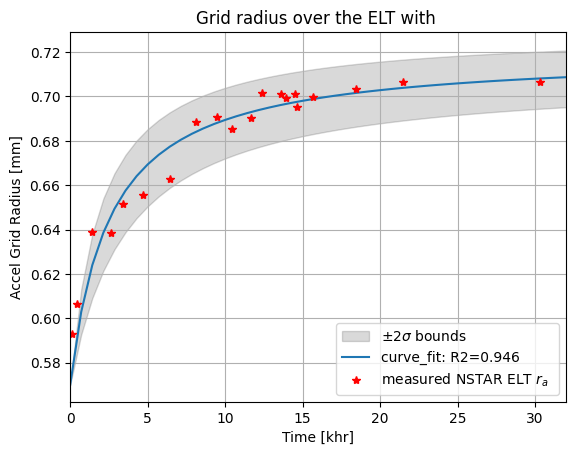

In [62]:
t = np.linspace(0,35)
xfit1   = accel_grid_erosion_func(t, a, b)
upper_bound = accel_grid_erosion_func(t, a+2*sigma_ab[0], b+2*sigma_ab[1])
lower_bound = accel_grid_erosion_func(t, a-2*sigma_ab[0], b-2*sigma_ab[1])

plt.fill_between(t, lower_bound, upper_bound,
                 color = 'black', alpha = 0.15, label=r"$\pm 2\sigma$ bounds")
plt.plot(t, xfit1, label=f'curve_fit: R2={R2:0.3}')

plt.plot(xdata, ydata, 'r*', label = r"measured NSTAR ELT $r_a$  ")
plt.grid(which='both')
plt.xlabel('Time [khr]')
plt.ylabel('Accel Grid Radius [mm]')
plt.xlim([0,32])
plt.title('Grid radius over the ELT with ')
plt.legend()

In [63]:
a = popt[0]
b = popt[1]
print(f"a = {popt[0]:0.3f}")
print(f"b = {popt[1]:0.3f}")

a = 0.563
b = 0.395


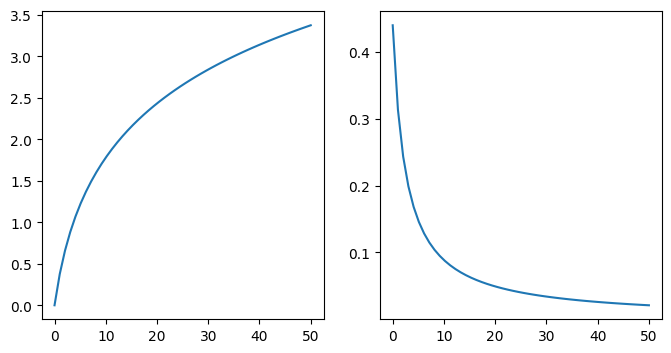

In [45]:
t = np.linspace(0,50)
dPdt = dfdt(t, a, b)
P = f(t, a, b)
fig, axs = plt.subplots(1, 2, figsize = (8, 4))
axs[0].plot(t, P)
axs[1].plot(t, dPdt)

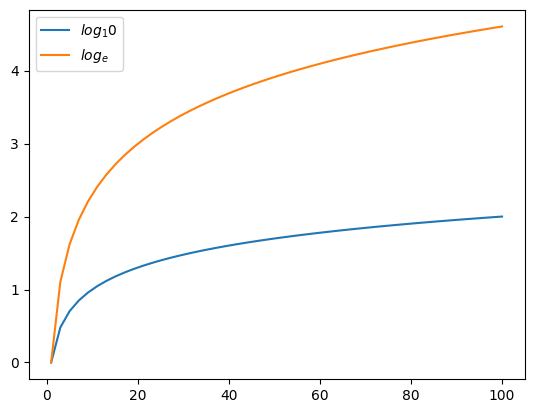

In [46]:
x = np.linspace(1,100)
y_log10 = np.log10(x)
y_loge = np.log(x)

plt.plot(x, y_log10, label = r'$log_10$')
plt.plot(x, y_loge, label = r'$log_e$')
plt.legend()
